In [61]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
# from paramets import *
# import json
from tqdm import tqdm

In [62]:
a, b, k = -1.0, 1.0, 100.0 #configuração: (a<0, b>0) ou (a>0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 16, 10001

a = torch.tensor(a, device='cpu')
b = torch.tensor(b, device='cpu')
k = torch.tensor(k, device='cpu')
dh = torch.tensor(dh, device='cpu')
dt = torch.tensor(dt, device='cpu')
Ng = torch.tensor(Ng, device='cpu')
Tf = torch.tensor(Tf, device='cpu')

## Rewrite the original code using torch

In [63]:
# Ng, Tf = 64, 10001

def laplacian(n):
    # Total number of grid points
    total_points = n * n

    matrix_laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            matrix_laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                matrix_laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                matrix_laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                matrix_laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                matrix_laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
                torch.tensor([row_indices, col_indices], dtype=torch.int64),
                torch.tensor(values, dtype=torch.float32),
                torch.Size((n*n,n*n))
                )
    return coo_matrix

master_list = []
def integrate(L, u, T):
    '''  simulates the equation and plots it at different instants '''
    T = torch.tensor([T], device='cpu')
    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cpu')
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method
        if (i==10000):
            master_list.append(u)

## Calculate the mean of configurations

In [64]:
def avg_realizations(master_list, Ng):
    """ Evaluate the average over the configurations (realizations)"""
    mean_config = []
    size = len(master_list)
    N = Ng*Ng
    temp = 0
    for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
        for config in range(size):
            temp += master_list[config][point]
        mean_config.append(temp/size)
        temp = 0
    mean_config = torch.tensor(mean_config)
    mean_config = mean_config.view((Ng, Ng))
    return mean_config

# mean_config = avg_realizations(master_list, Ng)
# plt.imshow(mean_config)
# plt.show()

In [65]:
def avg_final(mean_config, Ng):
    sum = 0 
    for x in range(Ng):
        for y in range(Ng):
            sum = sum + mean_config[x][y]
    return sum / (Ng*Ng)

# media_final(mean_config, Ng)

## RUN PIPELINE

In [66]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
N_real = 20

list_vev = []
for T in tqdm(range(0,50,1), desc="Processing", ncols=100, ascii=True):
  for realization in range(N_real):
    u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
    integrate(L, u, T)    # simulate

  mean_config = avg_realizations(master_list, Ng)
  VEV = avg_final(mean_config, Ng)
  list_vev.append(VEV)

Processing:   0%|                                                            | 0/50 [00:00<?, ?it/s]

Processing: 100%|###################################################| 50/50 [21:32<00:00, 25.85s/it]


In [67]:
T = range(0,50, 1)

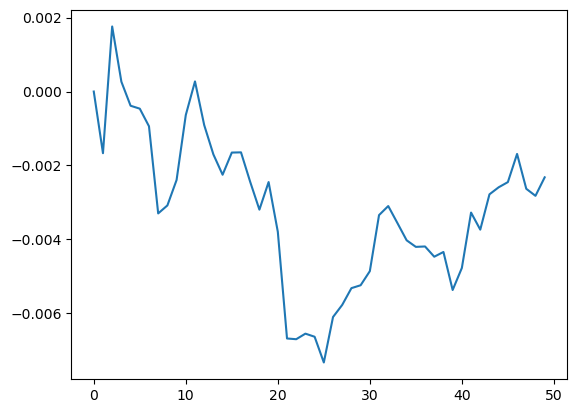

In [68]:
plt.plot(T, list_vev)